* 상장회사수 및 시가총액은 부동산투자회사, 선박투자회사 및 증권투자회사 등을 포함하고 있음 

* 유가증권시장 + KOSDAQ

* 상장회사수와 상장종목수는 다르다 (상장종목수는 우량주를 다 포함한 수)

KOSPI + KOSDAQ + DELISTING // 2012년부터

1.KOSPI, KOSDAQ 목록에서 거래되는 Symbol 얻기 // 보통주

2.DELISTING 목록에서 중복 제거 된 Symbol 얻기

///KRX정보데이터시스템 -> [12005] 전종목 기본정보///

kospi_stocks = fdr.StockListing('KOSPI') # 코스피

kosdaq_stocks = fdr.StockListing('KOSDAQ') # 코스닥
은 현재 주권 여부(단축코드가 7자리가 아니라 6자리)를 알 수 없기 때문에 쓰질 못한다.

/// 참고로 주권 코드는 A임 ///

In [ ]:
import FinanceDataReader as fdr

delisting_stocks = fdr.StockListing('KRX-DELISTING')

In [ ]:
# 주권 + 부동산투자회사 + 선박투자회사 + 투자회사 + 외국주권 + 주식예탁증권

con1 = (delisting_stocks['Market'] == 'KOSPI') | (delisting_stocks['Market'] == 'KOSDAQ')

con2 = (delisting_stocks['DelistingDate'] >= '2012-01-01')

con3 = (delisting_stocks['SecuGroup'] != '수익증권') & (delisting_stocks['SecuGroup'] != '신주인수권증서') \
        & (delisting_stocks['SecuGroup'] != '신주인수권증권')

delisted_symbol = delisting_stocks[con1 & con2 & con3].drop_duplicates('Symbol')

In [ ]:
# 우선 우선주는 제거함.

import re
con = delisted_symbol['Symbol'].str.contains(re.compile('[0]$'))
delisted_symbol = delisted_symbol[con]

In [ ]:
delisted_symbol

In [ ]:
import pandas as pd

# 1.불러오기
current_stocks = pd.read_csv('C:/Users/scw03/Desktop/StockProject/data/data_2837_20220426.csv', encoding='cp949')
current_stocks.rename(columns={'단축코드': 'Symbol'}, inplace=True)

In [ ]:
con1 = (current_stocks['시장구분'] == 'KOSPI') | (current_stocks['시장구분'] == 'KOSDAQ')

con2 = (current_stocks['주식종류'] == '보통주')

current_symbol = current_stocks[con1 & con2].drop_duplicates('Symbol')

In [ ]:
current_symbol

In [ ]:
pd.merge(left=current_symbol, right=delisted_symbol, on='Symbol', how='inner') # inner해서 결과값이 없으면 교집합이 없다는 뜻

In [ ]:
import time

def get_Historical_price_data(symbol_series):
    count = 0
    tolen = len(symbol_series)
    symbol = symbol_series.iloc[count]
    df1 = fdr.DataReader(symbol, start='2012-01-01', end='2022-03-30')
    level_0 = [symbol]
    level_1 = df1.columns
    df1.columns = pd.MultiIndex.from_product( [level_0, level_1] )
    count += 1
    while count <= tolen-1:
        symbol = symbol_series.iloc[count]
        temdf = fdr.DataReader(symbol, start='2012-01-01', end='2022-03-30')
        level_0 = [symbol]
        level_1 = temdf.columns
        temdf.columns = pd.MultiIndex.from_product( [level_0, level_1] )
        df1 = pd.concat([df1,temdf], axis=1)
        count += 1
        if count == int(tolen/4):
            print("약 25% 완료")
        if count == int(tolen/2):
            print("약 50% 완료")
        if count == int(3*tolen/4):
            print("약 75% 완료")
        time.sleep(float(0.5))
    return df1

In [ ]:
%%time
delisting_ohlcvc_data = get_Historical_price_data(delisted_symbol['Symbol'])

In [ ]:
delisting_ohlcvc_data

In [ ]:
%%time
current_ohlcvc_data = get_Historical_price_data(current_symbol['Symbol'])

In [ ]:
current_ohlcvc_data

In [ ]:
# 멀티인덱스에서 탐색할때는 낮은 레벨부터 검색한다.
# slice(None) 과 : 는 문법적으로 같은 의미이나 dataframe의 문법적 한계로 인해 :는 인식불가
delisting_ohlcvc_data.loc[:, (slice(None), 'Open')]

In [ ]:
complete_ohlcvc_data = pd.concat([current_ohlcvc_data,delisting_ohlcvc_data], axis=1)

In [ ]:
# csv 파일 저장하기
complete_ohlcvc_data.to_csv('C:/Users/scw03/Desktop/StockProject/data/complete_ohlcvc_data.csv', encoding='cp949')

# 데이터 베이스 완료

상장폐지 되면 데이터가 nan으로 나오고 거래 정지되면 종가 빼고 0.0 데이터를 얻는것 같음.

증권시장 총상장회사수는 거래 정지 된 것 놔두는 것이 더 정확하다.

In [179]:
"""# delisting 된 기업인지 검색
delisted_symbol[delisted_symbol['Symbol'] == '114130']

# delisting 안된 기업인지 검색
current_symbol[current_symbol['Symbol'] == '114130']

# 조건검색
con1 = (df_comple.loc['2014-04', (slice(None), 'Open')].count() != 22)
con2 = (df_comple.loc['2014-04', (slice(None), 'Open')].count() != 0)

df_comple_comple = df_comple.loc['2014-04', con1.loc[con1 & con2].index]"""

"# delisting 된 기업인지 검색\ndelisted_symbol[delisted_symbol['Symbol'] == '114130']\n\n# delisting 안된 기업인지 검색\ncurrent_symbol[current_symbol['Symbol'] == '114130']\n\n# 조건검색\ncon1 = (df_comple.loc['2014-04', (slice(None), 'Open')].count() != 22)\ncon2 = (df_comple.loc['2014-04', (slice(None), 'Open')].count() != 0)\n\ndf_comple_comple = df_comple.loc['2014-04', con1.loc[con1 & con2].index]"

In [1]:
import pandas as pd
# csv 파일 불러오기
complete_ohlcvc_data = pd.read_csv('C:/Users/scw03/Desktop/StockProject/data/complete_ohlcvc_data.csv',\
                                   encoding='cp949', index_col=0 , parse_dates=True, header=[0,1])

In [105]:
# 거래 정지되었지만 상장폐지는 안된 종목 제외
import numpy as np
df_comple = complete_ohlcvc_data.replace(0.0, np.nan)

In [170]:
def last_day(sample):
    """
    샘플링 기간중에 마지막 데이터를 리턴
    """
    return sample[-1]

df_comple_plot = df_comple.loc[:, (slice(None), 'Open')].count(axis=1).resample(rule='M').apply(last_day)
complete_ohlcvc_data_plot = complete_ohlcvc_data.loc[:, (slice(None), 'Open')].count(axis=1).resample(rule='M').apply(last_day)

In [159]:
# e나라지표에서 상장총회사수 가져오기 (excel -> csv로 변환)
# 2번째 줄 부터
df_totsym = pd.read_csv('C:/Users/scw03/Desktop/StockProject/data/stat_107901.csv', encoding='utf-8',skiprows=2, index_col=1 , parse_dates=True)

In [160]:
df_totsym = df_totsym.iloc[0][1:].str.replace(',','').apply(pd.to_numeric)
from datetime import datetime
df_totsym.index = df_comple_plot.index

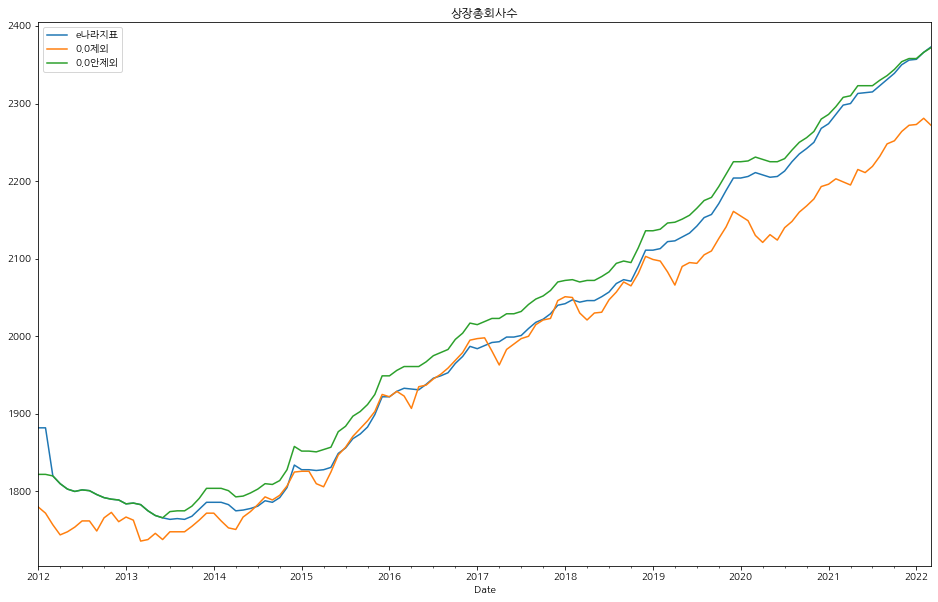

In [178]:
# 상장총회사수 그리기
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10))

mpl.rc('font', family='NanumGothic')

plt.title('상장총회사수')
df_totsym.plot(label='e나라지표')
df_comple_plot.plot(label='0.0제외')
complete_ohlcvc_data_plot.plot(label='0.0안제외')
plt.legend()